<center><h1>DSCI-552 Homework 4</h1></center>
<br>
<center><font size="4">Name: Wenhao Zhang</font></center>
<center><font size="4">USC ID: 7036767117</font></center>

## 1. The LASSO and Boosting for Regression

### (a) Download and read data
Download the Communities and Crime data from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.

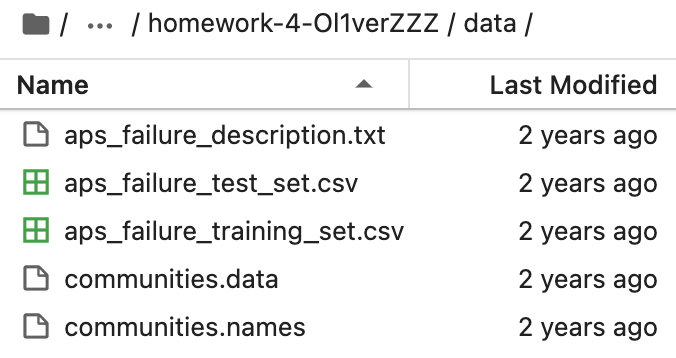

Have downloaded them!

And let us read data here.

In [1]:
import os
java_home = os.environ.get('JAVA_HOME', None)
if not java_home:
    java_path = '/Library/Java/JavaVirtualMachines/jdk-9.0.4.jdk/Contents/Home'
    os.environ['JAVA_HOME'] = java_path
else:
    print(java_home)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math
import xgboost as xgb
import weka.core.jvm as jvm
import javabridge
import weka.core.converters as converters
import weka.plot.classifiers as plcls
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from weka.classifiers import Classifier
from weka.classifiers import Evaluation
from weka.core.classes import Random
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

In [3]:
# Get the names of the features
features = []
with open('../data/communities.names', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if (line.startswith('@attribute')):
            features.append(line.split(" ")[1])
non_pre_features = features[:5]

data = pd.read_csv('../data/communities.data', header=None, names=features, na_values='?')
df = pd.DataFrame(data)
df

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [4]:
train_set = df[:1495]
test_set = df[1495:]
print(train_set.shape)
print(test_set.shape)

(1495, 128)
(499, 128)


### (b) 
The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [5]:
# Drop the non-predictive features
train_set = train_set.drop(columns = non_pre_features)
test_set = test_set.drop(columns = non_pre_features)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(train_set)

# Handle missing values in train set
train_set_imputed = imp.transform(train_set)
train_set_imputed = pd.DataFrame(data=train_set_imputed, columns=train_set.columns)

# Handle missing values in test set
test_set_imputed = imp.transform(test_set)
test_set_imputed = pd.DataFrame(data=test_set_imputed, columns=test_set.columns)

In [6]:
train_set_imputed

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.02,0.14,0.22,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.07,0.40,0.14,0.070000,0.050000,0.850000,0.500000,0.61,0.190000,0.20
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.03,0.12,0.01,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.30
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.15,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.03


In [7]:
test_set_imputed

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.01,0.23,0.73,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
1,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.01,0.18,0.02,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.11
2,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.01,0.18,0.00,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
3,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.06,0.13,0.16,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.06
4,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.03,0.23,0.06,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.09
495,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.163975,0.080502,0.713054,0.451883,0.00,0.190753,0.45
496,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.080000,0.060000,0.780000,0.000000,0.91,0.280000,0.23
497,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.020000,0.020000,0.790000,0.000000,0.22,0.180000,0.19


### (c) 
Plot a correlation matrix for the features in the data set.

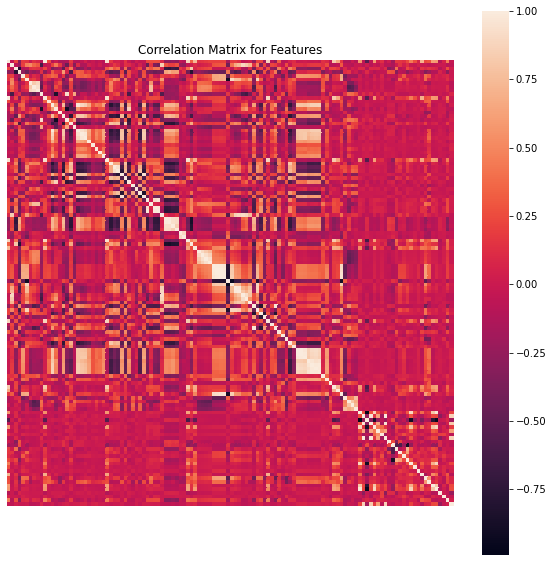

In [8]:
data_set_imputed = pd.concat([train_set_imputed, test_set_imputed], ignore_index=True)
data_set_imputed_X = data_set_imputed.iloc[:, :122]
data_set_imputed_y = data_set_imputed.iloc[:, -1]
correlation_matrix = data_set_imputed_X.corr()
fit, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation_matrix, xticklabels=False, yticklabels=False, square=True)
plt.title('Correlation Matrix for Features')
plt.show()

### (d)

Calculate the Coefficient of Variation CV for each feature, where CV = s/m , in which s is sample standard deviation and m is sample mean.

In [9]:
data_set_std = data_set_imputed_X.std()
data_set_mean = data_set_imputed_X.mean()
data_set_CV = data_set_std / data_set_mean
data_set_CV = pd.DataFrame(data_set_CV, columns=['CV'])
data_set_CV

,CV
population,2.203503
householdsize,0.353298
racepctblack,1.410920
racePctWhite,0.323782
racePctAsian,1.359162
...,...
PolicOperBudg,0.701202
LemasPctPolicOnPatr,0.120471
LemasGangUnitDeploy,0.360299
LemasPctOfficDrugUn,2.555266


### (e)
Pick ⌊√128⌋ features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

11 features with highest CV are selected.
                           CV
NumStreet            4.407702
NumInShelters        3.485481
NumIlleg             2.994196
NumImmig             2.900497
LemasPctOfficDrugUn  2.555266
NumUnderPov          2.304970
population           2.203503
numbUrban            2.001744
HousVacant           1.958780
LandArea             1.678031
racePctHisp          1.614278


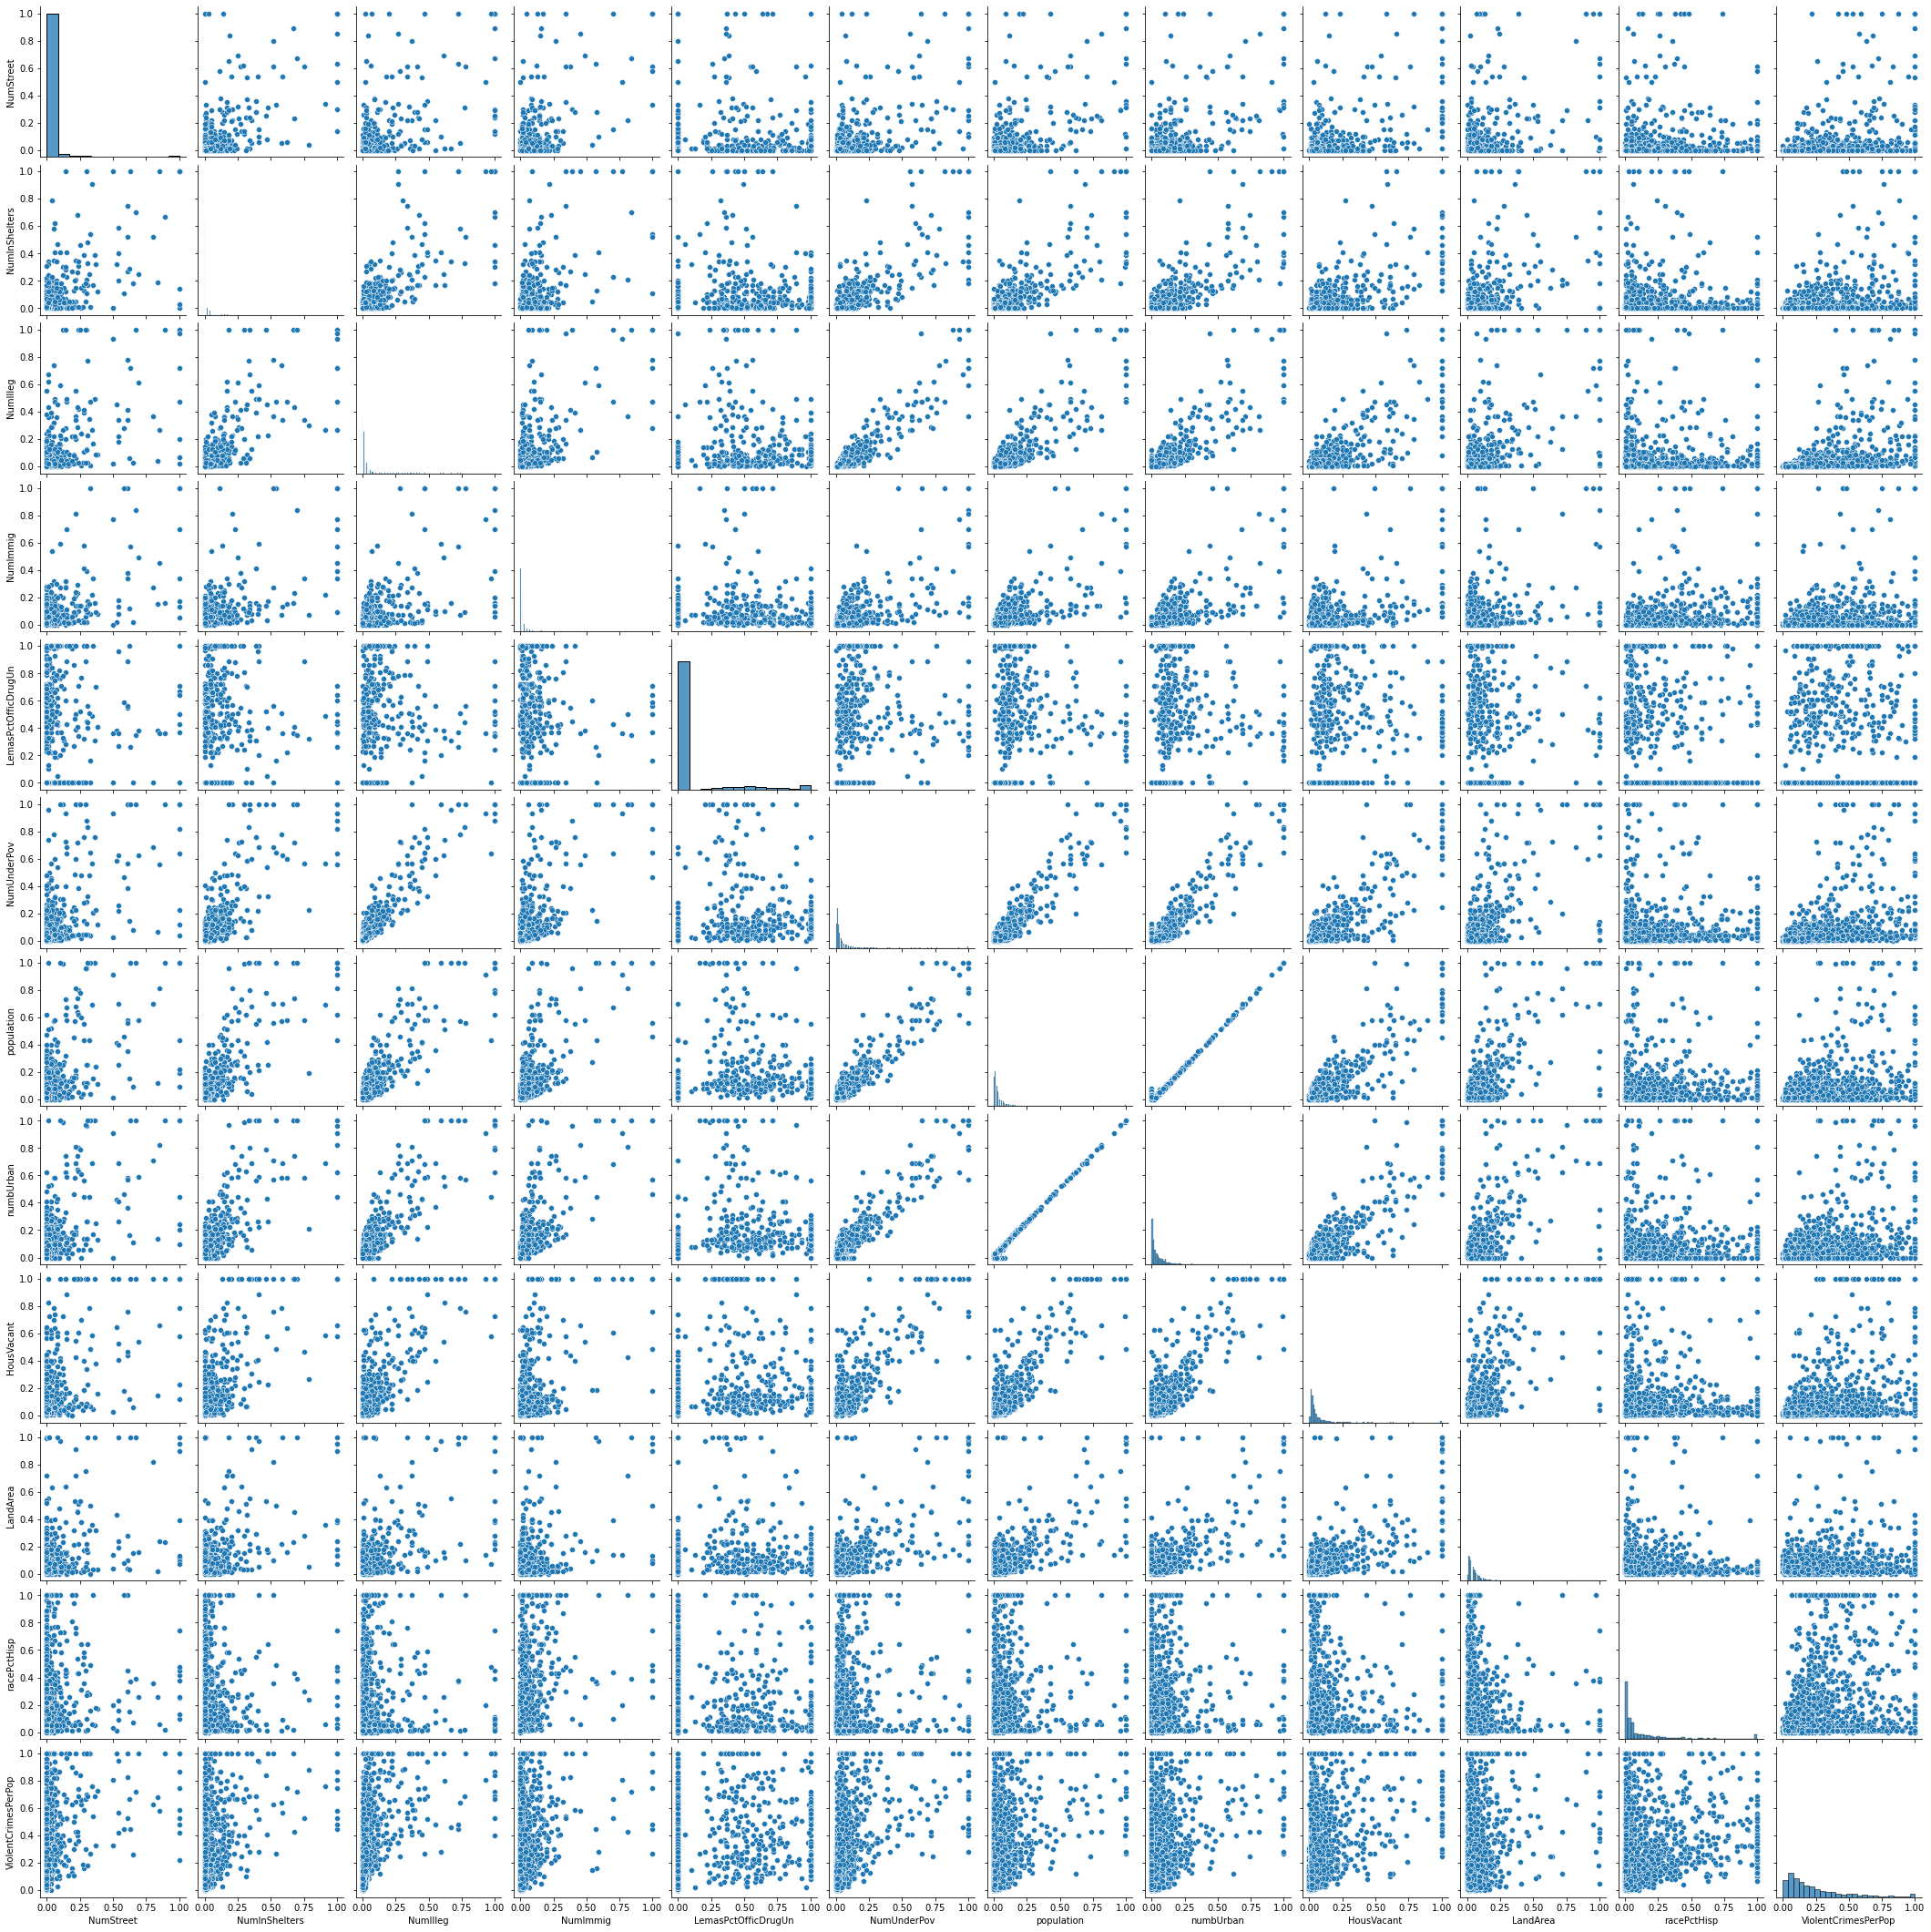

In [10]:
threshold = math.floor(math.sqrt(128))
print(str(threshold) + ' features with highest CV are selected.')
data_set_CV_sorted = data_set_CV.sort_values(ascending=False, by=['CV'])
highest_CV_features = data_set_CV_sorted[:threshold]
print(highest_CV_features)

selected_features = highest_CV_features.index.tolist()
selected_features_plus_label = selected_features.copy()
selected_features_plus_label.append('ViolentCrimesPerPop')
sns.pairplot(data_set_imputed[selected_features_plus_label])

**ANSWER**: It seems hard for me to draw any conlcusion about significance of those features just by the scatter plots, since there is no obvious relationships I can find between the label and the features.

<AxesSubplot:>

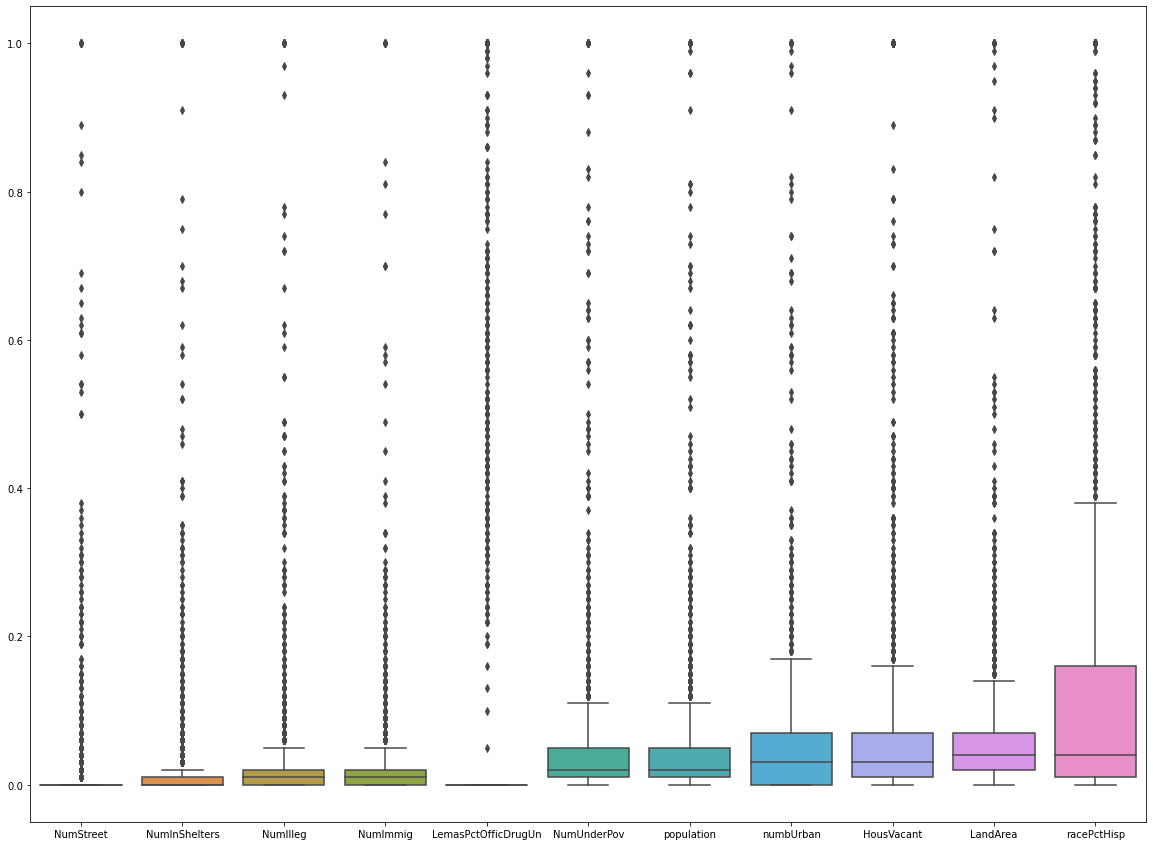

In [11]:
fig, axes = plt.subplots(figsize=(20, 15))
sns.boxplot(data=data_set_imputed[selected_features])

### (f)
Fit a linear model using least squares to the training set and report the test error.

In [12]:
X_train = train_set_imputed.iloc[:, :-1]
y_train = train_set_imputed.iloc[:, -1]
X_test = test_set_imputed.iloc[:, :-1]
y_test = test_set_imputed.iloc[:, -1]

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_predict = linear_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_predict)
print('For linear model', '-'*50)
print('The test MSE is:', mse_test)

For linear model --------------------------------------------------
The test MSE is: 0.018141971135530115


### (g) 
Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [13]:
alphas = [10 ** i for i in range(-5, 6)]
ridge_model = RidgeCV(alphas=alphas, cv=5)
ridge_model.fit(X_train, y_train)
y_predict = ridge_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_predict)
print('For ridge model', '-'*50)
print('The best λ is:', ridge_model.alpha_)
print('The test MSE is:', mse_test)

For ridge model --------------------------------------------------
The best λ is: 1.0
The test MSE is: 0.01773247499289664


### (h)
Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized features. Report the test error for both cases and compare them.

In [14]:
alphas = [10 ** i for i in range(-5, 6)]
lasso_model = LassoCV(alphas=alphas, cv=5, random_state=0, max_iter=10000)
lasso_model.fit(X_train, y_train)
y_predict = lasso_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_predict)
print('For LASSO model without standardization', '-'*50)
print('The best λ is:', lasso_model.alpha_)
print('The test MSE is:', mse_test)

lasso_selected_features = pd.DataFrame(data=lasso_model.coef_[lasso_model.coef_!=0], 
                                       index=X_test.columns[lasso_model.coef_!=0], columns=['coefficient'])
print('The selected features are:')
lasso_selected_features

For LASSO model without standardization --------------------------------------------------
The best λ is: 0.0001
The test MSE is: 0.01778608951910212
The selected features are:


,coefficient
racepctblack,0.273052
racePctAsian,-0.017982
agePct12t21,0.076001
agePct12t29,-0.291125
agePct65up,0.003873
...,...
PctUsePubTrans,-0.047532
PolicCars,0.000543
LemasPctPolicOnPatr,0.021727
LemasGangUnitDeploy,0.040690


In [15]:
# Repeat with standardized features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)
lasso_model_std = LassoCV(alphas=alphas, cv=5, random_state=0, max_iter=10000)
lasso_model_std.fit(X_train_std, y_train)
y_predict = lasso_model_std.predict(X_test_std)
mse_test = mean_squared_error(y_test, y_predict)
print('For LASSO model with standardization', '-'*50)
print('The best λ is:', lasso_model_std.alpha_)
print('The test MSE is:', mse_test)

lasso_std_selected_features = pd.DataFrame(data=lasso_model_std.coef_[lasso_model_std.coef_!=0], 
                                       index=X_test.columns[lasso_model_std.coef_!=0], columns=['coefficient'])
print('The selected features are:')
lasso_std_selected_features

For LASSO model with standardization --------------------------------------------------
The best λ is: 0.001
The test MSE is: 0.017949170546600612
The selected features are:


,coefficient
racepctblack,0.066805
agePct12t21,0.005265
agePct12t29,-0.028572
pctUrban,0.015660
pctWWage,-0.008793
...,...
PopDens,0.002540
PctUsePubTrans,-0.007038
PolicCars,0.002432
LemasPctPolicOnPatr,0.002066


**Comparision**: The test mse becomes even larger with standardized features than without standardization. The reason for this may be that features are aleady normalized.

### (i)
Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

In [16]:
best_M = 1
min_mse = float("inf")

for m in range(1, 123):
    pcr_model = LinearRegression()
    pca = PCA(n_components=m)
    X_train_reduced = pca.fit_transform(X_train)
    mse = (-1*cross_val_score(pcr_model, X_train_reduced, y_train, cv=5, scoring='neg_mean_squared_error')).mean()
    if mse < min_mse:
        best_M = m
        min_mse = mse
print('For PCR model', '-'*50)
print('The best M is:', best_M)
print('The corresponding cv MSE is:', min_mse)

For PCR model --------------------------------------------------
The best M is: 96
The corresponding cv MSE is: 0.019415445834944554


In [17]:
# Refit the model with best M to the whole training set
pca = PCA(n_components=best_M)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)

pcr_model = LinearRegression()
pcr_model.fit(X_train_reduced, y_train)
y_predict = pcr_model.predict(X_test_reduced)
mse_test = mean_squared_error(y_test, y_predict)
print('For PCR model with the best M =', best_M, '-'*50)
print('The test MSE is:', mse_test)

For PCR model with the best M = 96 --------------------------------------------------
The test MSE is: 0.028713772109626806


### (j) 
In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation.

In [18]:
alphas = [10 ** i for i in range(-5, 6)]
best_alpha = 10 ** (-5)
min_rmse = float("inf")

dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
for alpha in alphas:
    params = {'objective':'reg:squarederror', 'max_depth': 2, 'alpha': alpha}
    cv_results = xgb.cv(params, dtrain=dmatrix_train, nfold=5, metrics="rmse", num_boost_round=100)
    rmse = np.mean(cv_results['test-rmse-mean'])
    if rmse < min_rmse:
        best_alpha = alpha
        min_rmse = rmse
print('For L1-penalized gradient boosting tree', '-'*50)
print('The best alpha is:', best_alpha)
print('The corresponding cv MSE is:', min_rmse**2)

For L1-penalized gradient boosting tree --------------------------------------------------
The best alpha is: 1
The corresponding cv MSE is: 0.0213805159189253


In [19]:
# Refit the model with best alpha to the whole training set
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=2, alpha=best_alpha)
xgb_model.fit(X_train, y_train)
y_predict = xgb_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_predict)
print('For L1-penalized gradient boosting tree with best alpha =', best_alpha, '-'*50)
print('The test MSE is:', mse_test)

For L1-penalized gradient boosting tree with best alpha = 1 --------------------------------------------------
The test MSE is: 0.017229602067821877


## 2. Tree-Based Methods

### (a) Read and download data
Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks. The dataset contains a training set and a test
set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

Have downloaded them!

And let us read data here.

In [20]:
train_set = pd.read_csv('../data/aps_failure_training_set.csv', skiprows=20)
test_set = pd.read_csv('../data/aps_failure_test_set.csv', skiprows=20)
train_set.replace('na', np.nan, inplace=True)
test_set.replace('na', np.nan, inplace=True)
data_set = pd.concat([train_set, test_set], ignore_index=True)
data_set

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,NaN,0,NaN,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,NaN,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,NaN,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,neg,81852,NaN,2130706432,892,0,0,0,0,0,...,632658,273242,510354,373918,349840,317840,960024,25566,0,0
75996,neg,18,0,52,46,8,26,0,0,0,...,266,44,46,14,2,0,0,0,0,0
75997,neg,79636,NaN,1670,1518,0,0,0,0,0,...,806832,449962,778826,581558,375498,222866,358934,19548,0,0
75998,neg,110,NaN,36,32,0,0,0,0,0,...,588,210,180,544,1004,1338,74,0,0,0


### (b) Data Preparation
This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.

#### i.
Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

**ANSWER**:

(Citation: https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779) 
* 1. Imputation Using (Mean/Median) Values
* 2. Imputation Using (Most Frequent) or (Zero/Constant) Values
* 3. Imputation Using k-NN
* 4. Imputation Using Multivariate Imputation by Chained Equation (MICE)
* 5. Imputation Using Deep Learning (Datawig)
* 6. Stochastic regression imputation
* 7. Extrapolation and Interpolation
* 8. Hot-Deck imputation

Here I will do imputation using mean values.

In [21]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_data_set = data_set.iloc[:, 1:]
y_data_set = data_set.iloc[:, 0]
X_data_set_imputed = imp.fit_transform(X_data_set)
X_data_set_imputed = pd.DataFrame(data=X_data_set_imputed, columns=X_data_set.columns)
X_data_set_imputed

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.72556,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.72556,0.000000e+00,150629.962105,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.72556,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.00000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.72556,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,81852.0,0.72556,2.130706e+09,892.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
75996,18.0,0.00000,5.200000e+01,46.000000,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
75997,79636.0,0.72556,1.670000e+03,1518.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
75998,110.0,0.72556,3.600000e+01,32.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


#### ii.
For each of the 170 features, calculate the coefficient of variation CV = s/m , where s is sample standard deviation and m is sample mean.

In [22]:
data_set_std = X_data_set_imputed.std()
data_set_mean = X_data_set_imputed.mean()
data_set_CV = data_set_std / data_set_mean
data_set_CV = pd.DataFrame(data_set_CV, columns=['CV'])
data_set_CV

,CV
aa_000,4.328608
ab_000,2.178273
ac_000,2.167653
ad_000,206.721500
ae_000,22.293670
...,...
ee_007,4.885098
ee_008,3.335037
ee_009,5.753933
ef_000,47.919544


#### iii.
Plot a correlation matrix for your features using pandas or any other tool.

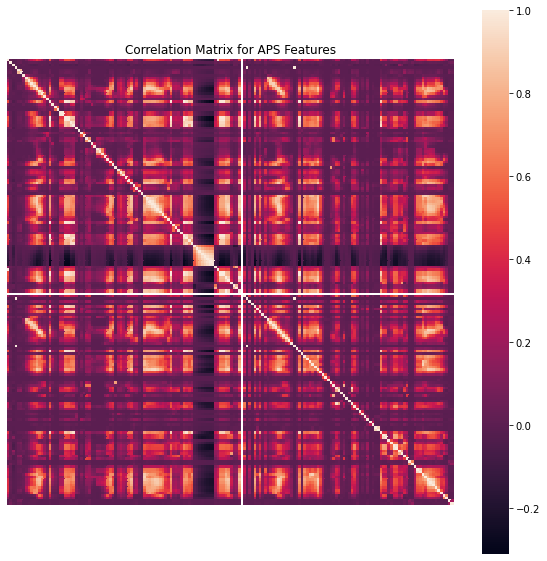

In [23]:
correlation_matrix = X_data_set_imputed.corr()
fit, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation_matrix, xticklabels=False, yticklabels=False, square=True)
plt.title('Correlation Matrix for APS Features')
plt.show()

#### iv.
Pick ⌊√170⌋ features with highest CV , and make scatter plots and box plots
for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [24]:
threshold = math.floor(math.sqrt(170))
print(str(threshold) + ' features with highest CV are selected.')
data_set_CV_sorted = data_set_CV.sort_values(ascending=False, by=['CV'])
highest_CV_features = data_set_CV_sorted[:threshold]
print(highest_CV_features)

13 features with highest CV are selected.
                CV
cf_000  207.270274
co_000  206.876129
ad_000  206.721500
cs_009  192.522611
dj_000  122.128153
as_000  113.882755
dh_000  112.652450
df_000  111.369666
ag_000   91.460654
au_000   86.085638
ak_000   78.622988
az_009   77.999556
ay_009   77.461101


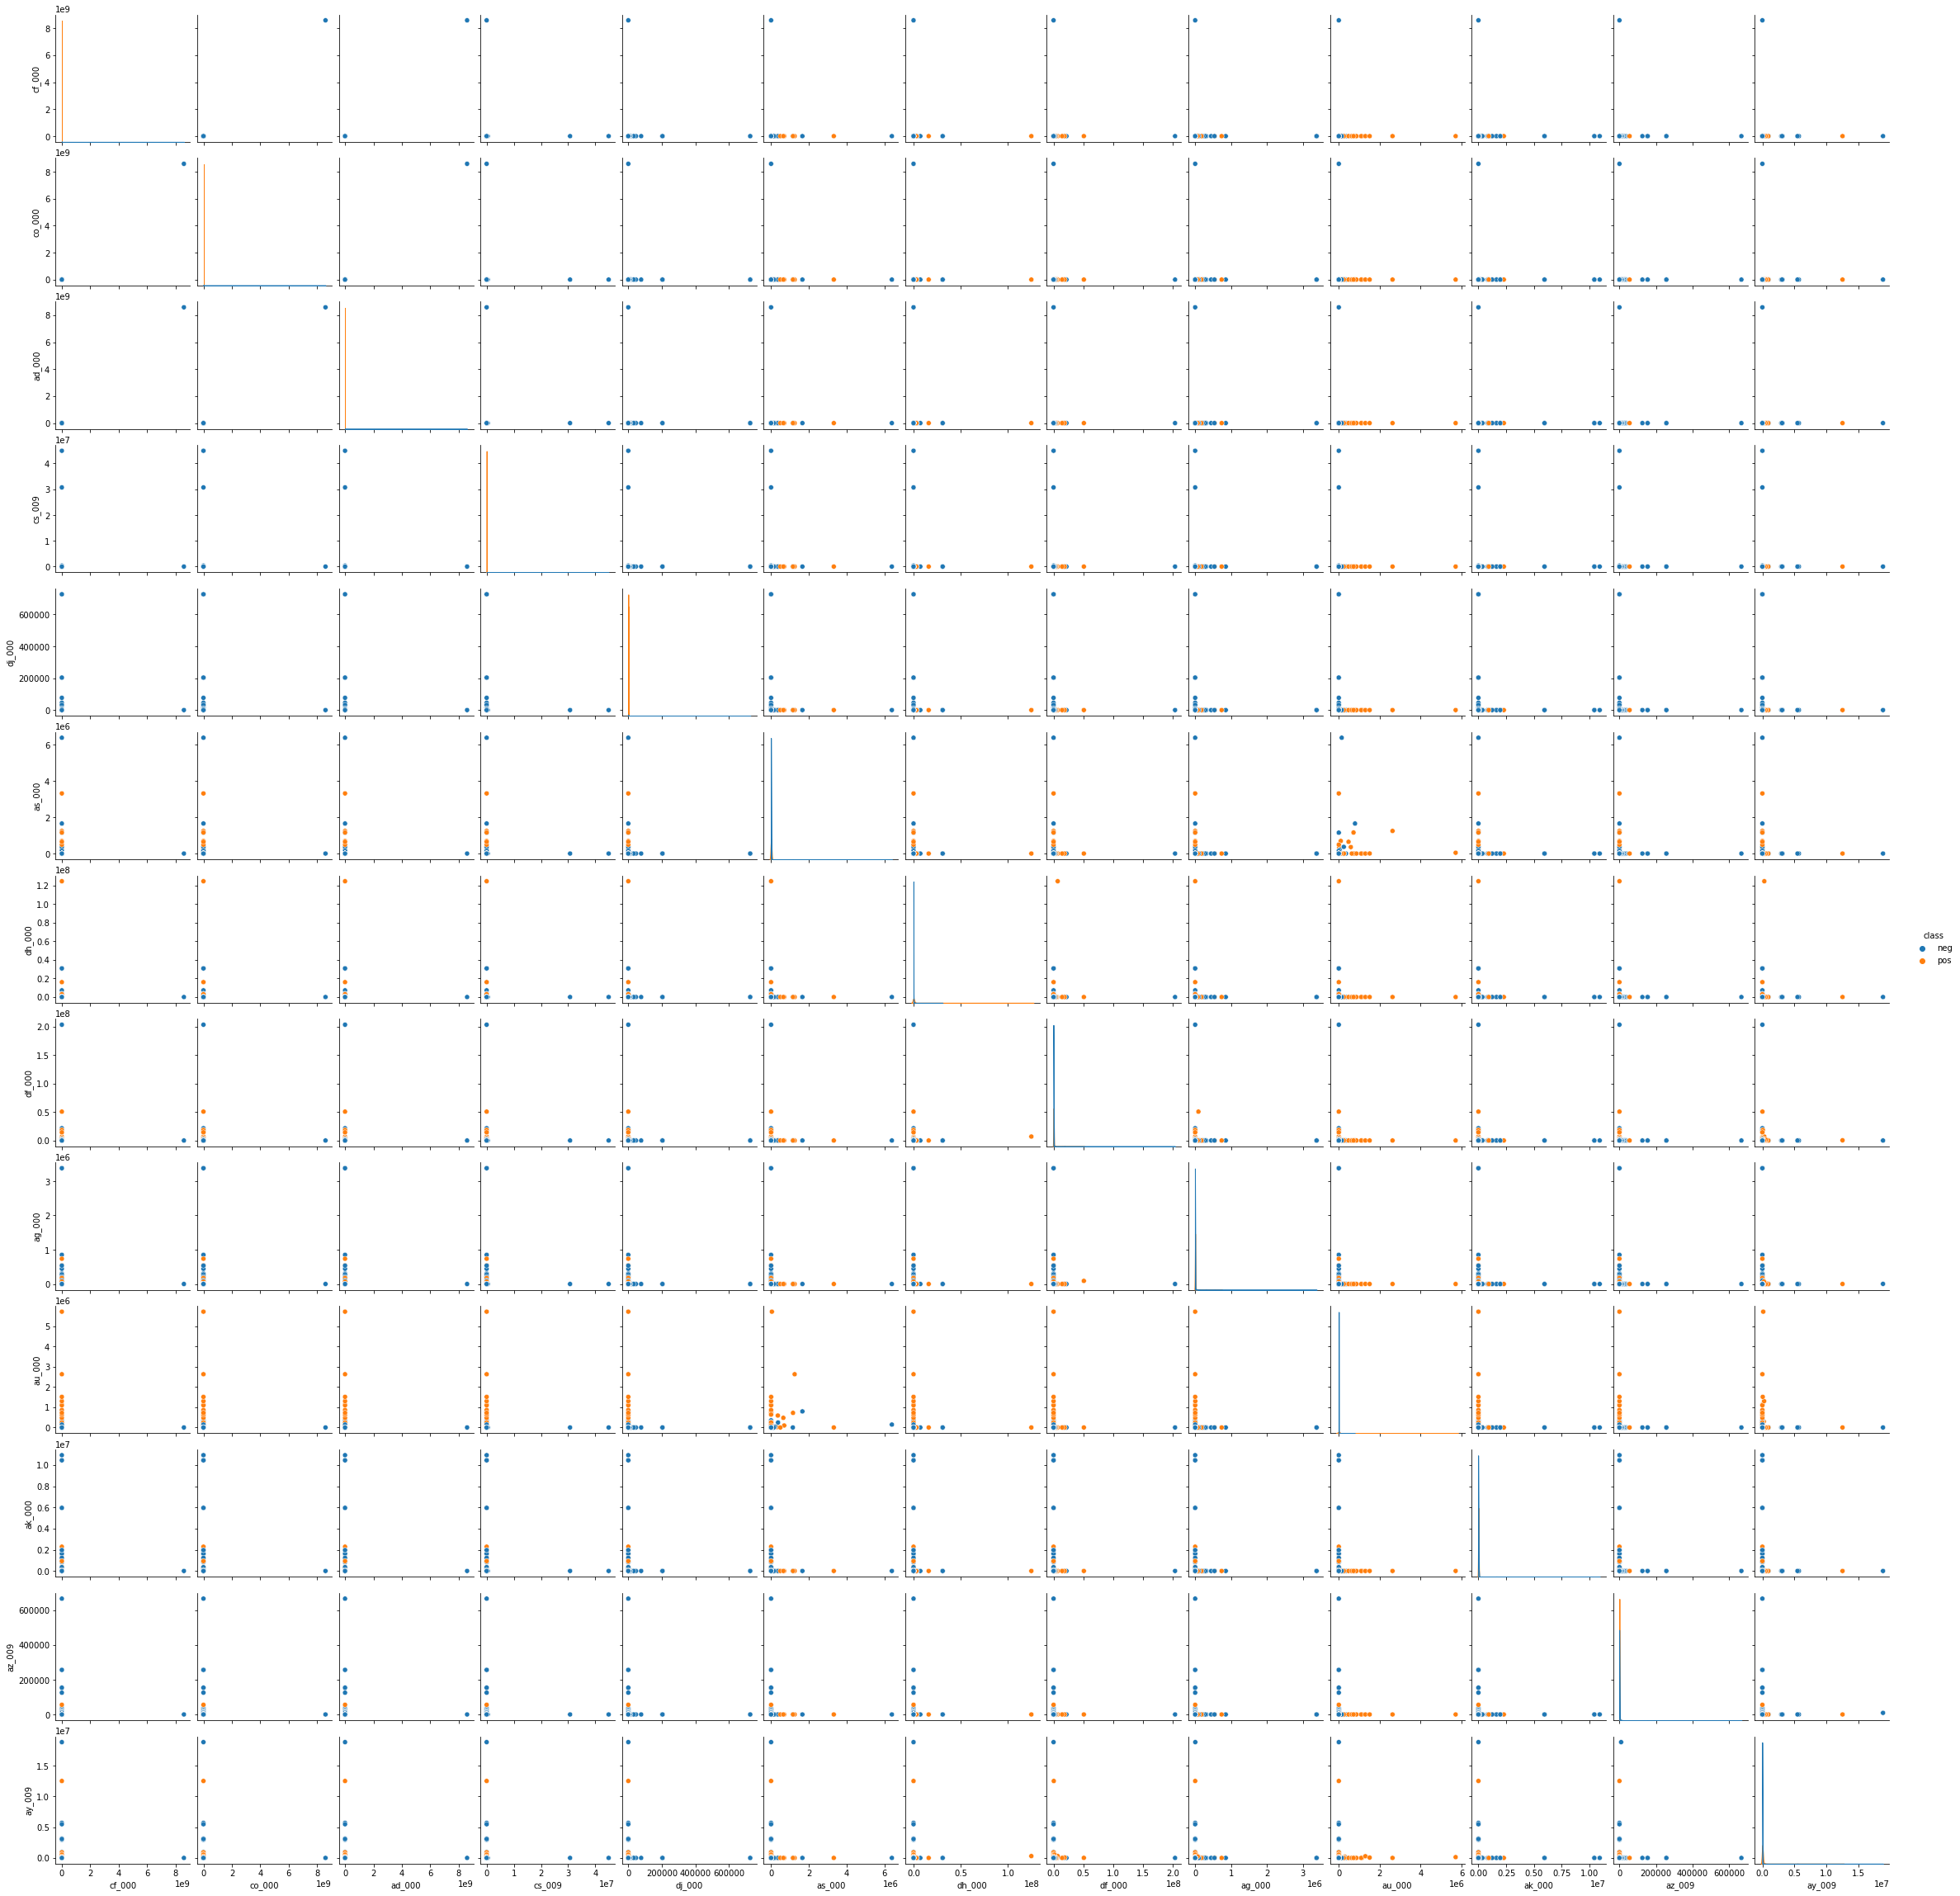

In [25]:
# scatter plots
selected_features = highest_CV_features.index.tolist()
selected_features_plus_label = selected_features.copy()
selected_features_plus_label.append('class')
data_set_imputed = X_data_set_imputed.copy()
data_set_imputed['class'] = y_data_set
sns.pairplot(data_set_imputed[selected_features_plus_label], hue='class')

**ANSWER**: I think **as_000**, **dh_000**, **df_000**, and **au_000** seems like features of significance. For these features, when the value becomes larger, positive cases account for majority obviously.

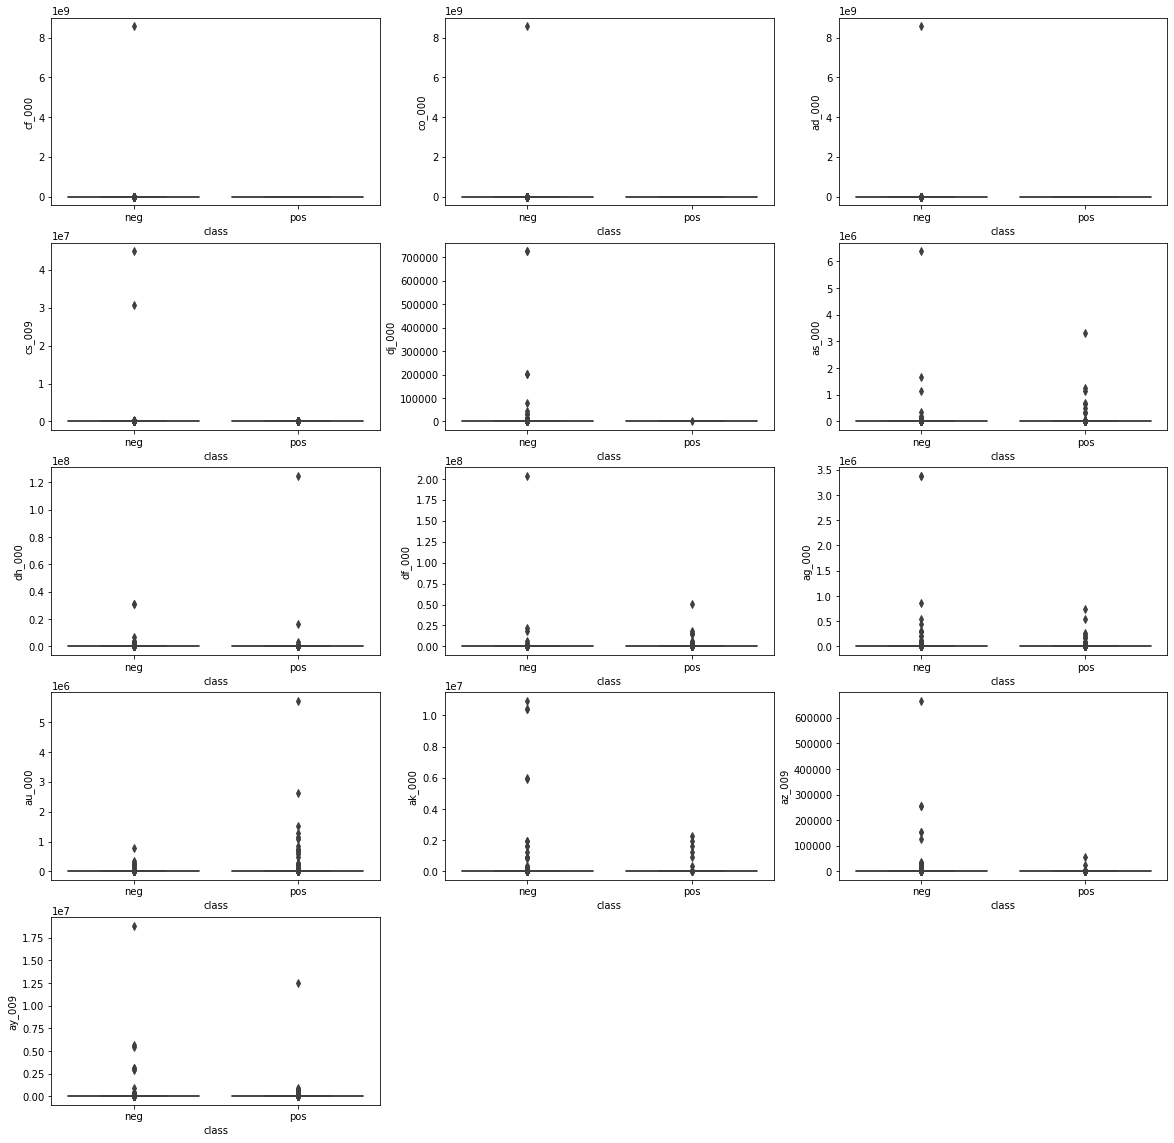

In [26]:
# box plots
plt.figure(figsize=(20,20))
i = 1
for feature in selected_features:
    plt.subplot(5,3,i)
    i += 1
    sns.boxplot(data=data_set_imputed[selected_features_plus_label], x="class", y=feature)

There are too many outliers for each feature. So I will use "showfliers=False" to ignore outliers and show the boxplot again.

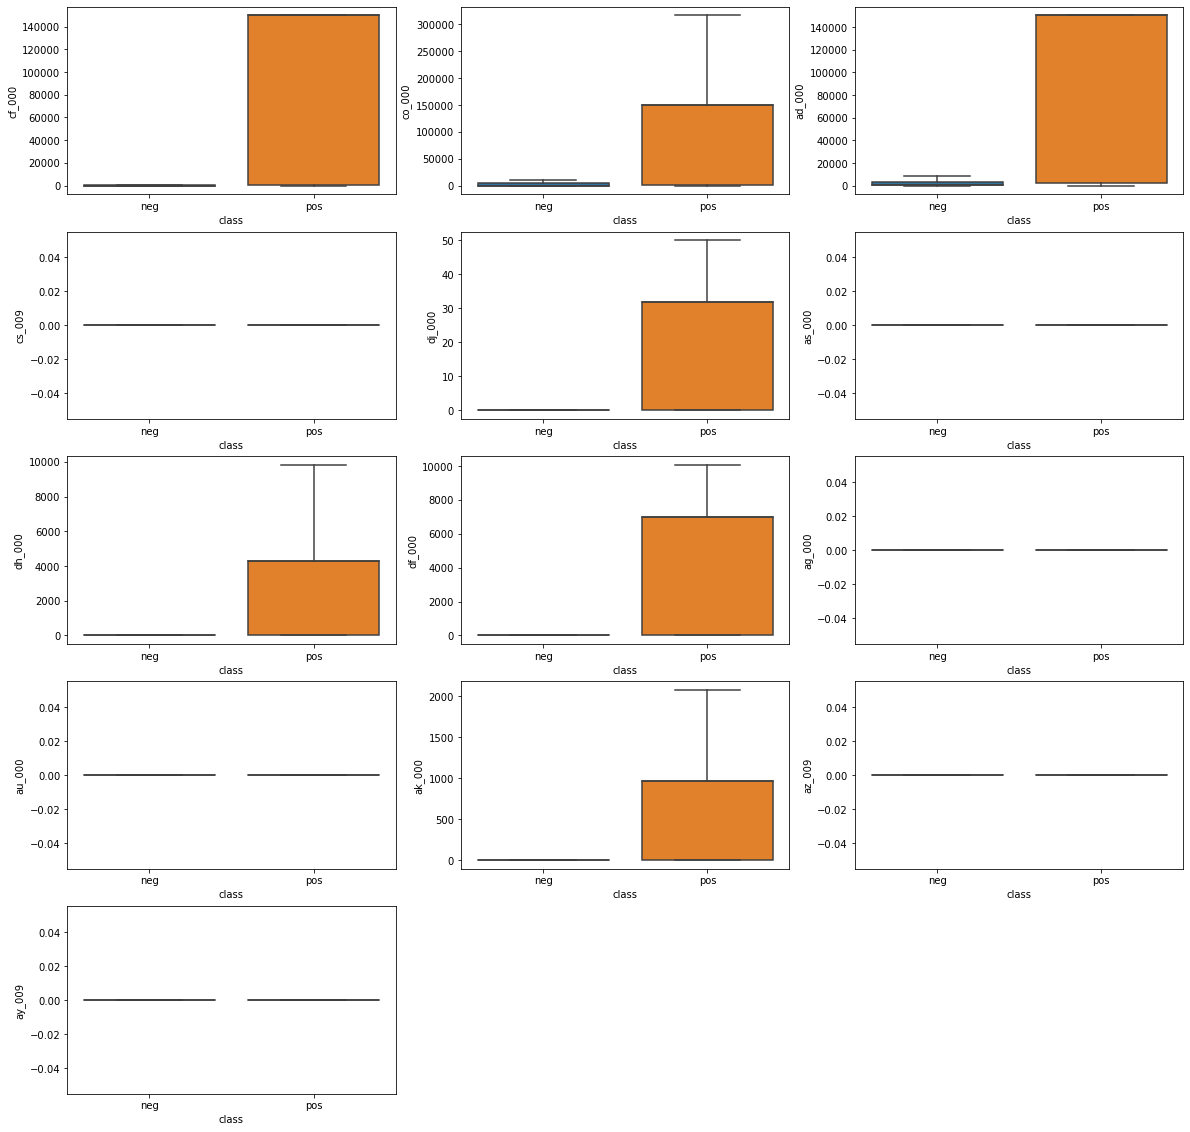

In [27]:
# box plots ignoring outliers
plt.figure(figsize=(20,20))
i = 1
for feature in selected_features:
    plt.subplot(5,3,i)
    i += 1
    sns.boxplot(data=data_set_imputed[selected_features_plus_label], x="class", y=feature, showfliers=False)

#### v.
Determine the number of positive and negative data. Is this data set imbalanced?

In [28]:
train_set['class'].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

In [29]:
test_set['class'].value_counts()

neg    15625
pos      375
Name: class, dtype: int64

**ANSWER**: This data set is obviously imbalanced.

### (c)
Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [30]:
# Change label to 1 and 0
data_set_imputed.replace('pos', 1, inplace=True)
data_set_imputed.replace('neg', 0, inplace=True)

# Split data set to training set and test set
X_train = data_set_imputed.iloc[:60000, :170]
y_train = data_set_imputed.iloc[:60000, -1]
X_test = data_set_imputed.iloc[60000:, :170]
y_test = data_set_imputed.iloc[60000:, -1]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 170)
(60000,)
(16000, 170)
(16000,)


For training set --------------------------------------------------
Confusion Matrix: 
 [[58978    22]
 [  812   188]]
ROC and AUC:


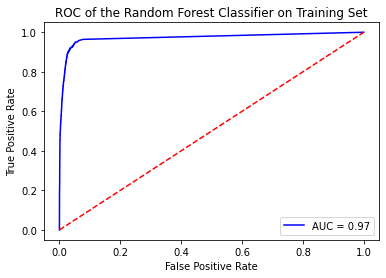

Misclassification rate: 0.013900000000000023
Out of Bag error: 0.014100000000000001


In [31]:
RF_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, oob_score=True)
RF_model.fit(X_train, y_train)

# For training set
print('For training set', '-'*50)
y_predict = RF_model.predict(X_train)

# confusion matrix
c_m = confusion_matrix(y_train, y_predict)
print('Confusion Matrix: \n', c_m)

# ROC and AUC
y_predict_proba = RF_model.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_predict_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC and AUC:')
plt.title('ROC of the Random Forest Classifier on Training Set')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# misclassification rate
print('Misclassification rate:', 1-RF_model.score(X_train, y_train))

# Out of Bag error
print('Out of Bag error:', 1-RF_model.oob_score_)

For test set --------------------------------------------------
Confusion Matrix: 
 [[15624     1]
 [  304    71]]
ROC and AUC:


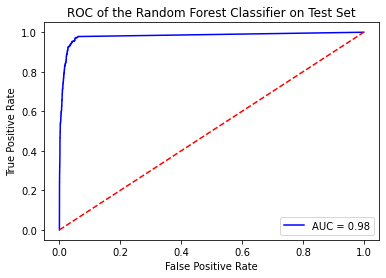

Misclassification rate: 0.019062499999999982
Out of Bag error: 0.014100000000000001


In [32]:
# For test set
print('For test set', '-'*50)
y_predict = RF_model.predict(X_test)

# confusion matrix
c_m = confusion_matrix(y_test, y_predict)
print('Confusion Matrix: \n', c_m)

# ROC and AUC
y_predict_proba = RF_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC and AUC:')
plt.title('ROC of the Random Forest Classifier on Test Set')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# misclassification rate
print('Misclassification rate:', 1-RF_model.score(X_test, y_test))

# Out of Bag error
print('Out of Bag error:', 1-RF_model.oob_score_)

**ANSWER**: By comparison, we can see Out of Bag error estimate is smaller than test error.

### (d)
Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.

For training set using balanced mode --------------------------------------------------
Confusion Matrix: 
 [[55203  3797]
 [   53   947]]
ROC and AUC:


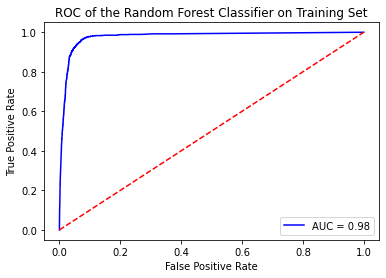

Misclassification rate: 0.0641666666666667
Out of Bag error: 0.06425000000000003


In [33]:
# Use class_weight='balanced' to compensate for class imbalance
# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies 
# in the input data as n_samples / (n_classes * np.bincount(y)).
RF_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, oob_score=True, class_weight='balanced')
RF_model.fit(X_train, y_train)

# For training set
print('For training set using balanced mode', '-'*50)
y_predict = RF_model.predict(X_train)

# confusion matrix
c_m = confusion_matrix(y_train, y_predict)
print('Confusion Matrix: \n', c_m)

# ROC and AUC
y_predict_proba = RF_model.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_predict_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC and AUC:')
plt.title('ROC of the Random Forest Classifier on Training Set')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# misclassification rate
print('Misclassification rate:', 1-RF_model.score(X_train, y_train))

# Out of Bag error
print('Out of Bag error:', 1-RF_model.oob_score_)

For test set using balanced mode --------------------------------------------------
Confusion Matrix: 
 [[14673   952]
 [   12   363]]
ROC and AUC:


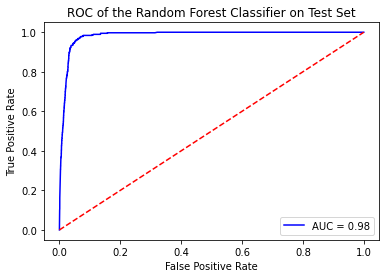

Misclassification rate: 0.060250000000000026
Out of Bag error: 0.06425000000000003


In [34]:
# For test set
print('For test set using balanced mode', '-'*50)
y_predict = RF_model.predict(X_test)

# confusion matrix
c_m = confusion_matrix(y_test, y_predict)
print('Confusion Matrix: \n', c_m)

# ROC and AUC
y_predict_proba = RF_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC and AUC:')
plt.title('ROC of the Random Forest Classifier on Test Set')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# misclassification rate
print('Misclassification rate:', 1-RF_model.score(X_test, y_test))

# Out of Bag error
print('Out of Bag error:', 1-RF_model.oob_score_)

**ANSWER**: Comparing the results with those of 2c, we can get the table below.

| Model | Test Error | Recall | Precision |
| ----- | ---------- | ------ | --------- |
| Random Forest without Balanced Mode | 0.019062499999999982 | 0.1893 | 0.9861 |
| Random Forest with Balanced Mode | 0.060250000000000026 | 0.9680 | 0.2760 |

We could see that the overall test error becomes higher after using balanced mode. However, the recall (true positive rate) also becomes much larger using balanced mode, though precision becomes lower. For this data set, I believe recall is more important than  precsion, because we want to find out all APS failures even with low precision. Therefore, though with a larger test error, I think the model using balanced mode is the better one.

### (e) Model Trees
In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has $∑_jβ_jX_j > s$. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node.

One of the methods that can be used at each node is Logistic Regression. One can use scikit learn to call Weka to train Logistic Model Trees for classification. Train Logistic Model Trees for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [35]:
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/pc/opt/anaconda3/lib/python3.8/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/pc/opt/anaconda3/lib/python3.8/site-packages/javabridge/jars/runnablequeue.jar', '/Users/pc/opt/anaconda3/lib/python3.8/site-packages/javabridge/jars/cpython.jar', '/Users/pc/opt/anaconda3/lib/python3.8/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/pc/opt/anaconda3/lib/python3.8/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


In [52]:
# Write new csv to prepare for Weka
aps_data_set = pd.concat([X_data_set_imputed, y_data_set], axis=1)
train_set = aps_data_set.iloc[:60000]
test_set = aps_data_set.iloc[60000:]
train_set.to_csv('../data/aps_train_weka.csv', index=False)
test_set.to_csv('../data/aps_test_weka.csv', index=False)

In [53]:
# Load data and specify the position of label
weka_train = converters.load_any_file('../data/aps_train_weka.csv')
weka_test = converters.load_any_file('../data/aps_test_weka.csv')
weka_train.class_is_last()
weka_test.class_is_last()

#### LMT model on Training Set

In [38]:
# Build LMT model and do 5-fold CV on training set
LMT_model = Classifier(classname="weka.classifiers.trees.LMT")
evaluation = Evaluation(weka_train)
evaluation.crossvalidate_model(classifier=LMT_model, data=weka_train, num_folds=5, rnd=Random(1))

In [39]:
# confusion matrix
print('Confusion Matrix:')
print(evaluation.confusion_matrix)

Confusion Matrix:
[[58852.   148.]
 [  352.   648.]]


ROC and AUC:


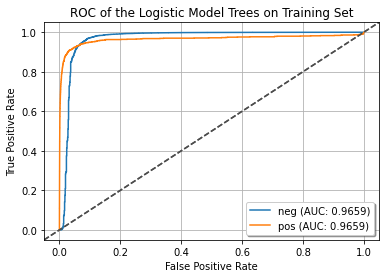

In [40]:
# ROC and AUC
print('ROC and AUC:')
plcls.plot_roc(evaluation, class_index=[0,1], title='ROC of the Logistic Model Trees on Training Set')

In [41]:
# train error and other information
print(evaluation.summary())
print(evaluation.class_details())


Correctly Classified Instances       59500               99.1667 %
Incorrectly Classified Instances       500                0.8333 %
Kappa statistic                          0.7174
Mean absolute error                      0.0119
Root mean squared error                  0.0825
Relative absolute error                 36.3706 %
Root relative squared error             64.4397 %
Total Number of Instances            60000     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.997    0.352    0.994      0.997    0.996      0.722    0.966     0.998     neg
                 0.648    0.003    0.814      0.648    0.722      0.722    0.966     0.757     pos
Weighted Avg.    0.992    0.346    0.991      0.992    0.991      0.722    0.966     0.994     



#### LMT model on Test Set

In [42]:
# Evaluate the LMT model on test set
LMT_model.build_classifier(weka_train)

Confusion Matrix: 
 [[15577    48]
 [  106   269]]
ROC and AUC:


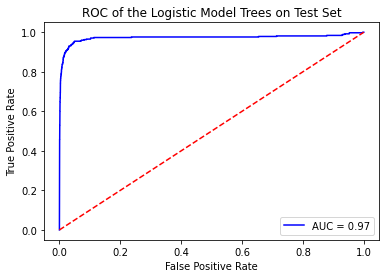

Test error: 0.009624999999999995


In [55]:
y_predict = []
for instance in weka_test:
    y_predict.append(LMT_model.classify_instance(instance))

# confusion matrix
c_m = confusion_matrix(y_test, y_predict, labels=[0,1])
print('Confusion Matrix: \n', c_m)

# ROC and AUC
y_predict_proba = LMT_model.distributions_for_instances(weka_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC and AUC:')
plt.title('ROC of the Logistic Model Trees on Test Set')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# test error
test_error = 1-accuracy_score(y_test, y_predict)
print('Test error:', test_error)

**ANSWER**: The estimated error of the trained model is 0.008333, and the test error is 0.009624999999999995. The latter one is a little bit larger.

### (f)
Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.8 Train a Logistic Model Tree using the pre-processed data and repeat 2e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE.

#### Apply SMOTE during CV

In [62]:
y_train_str = y_data_set.iloc[:60000]
y_test_str = y_data_set.iloc[60000:]

# Apply SMOTE during CV
validate_error_list = []
k_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for train_index, validate_index in k_fold.split(X_train, y_train_str):
    print('Fold'+str(len(validate_error_list)+1), 'started...')
    
    X_train_fold = X_train.iloc[train_index,:]
    y_train_fold = y_train_str.iloc[train_index]
    X_validate_fold = X_train.iloc[validate_idex,:]
    y_validate_fold = y_train_str.iloc[validate_idex]
    
    # Apply SMOTE to the training part of each fold
    sm = SMOTE(random_state=42)
    X_train_smoted, y_train_smoted = sm.fit_resample(X_train_fold, y_train_fold)
    
    # Convert the sampled data to csv files
    train_smoted = pd.concat([X_train_smoted, y_train_smoted], axis=1)
    validate_set = pd.concat([X_validate_fold, y_validate_fold], axis=1)
    train_smoted.to_csv('../data/tmp_train_smoted.csv', index=False)
    validate_set.to_csv('../data/tmp_validate_set.csv', index=False)
    
    # Load files using weka
    weka_train_smoted = converters.load_any_file('../data/tmp_train_smoted.csv')
    weka_validate_set = converters.load_any_file('../data/tmp_validate_set.csv')
    weka_train_smoted.class_is_last()
    weka_validate_set.class_is_last()
    
    # Build LMT model
    model = Classifier(classname='weka.classifiers.trees.LMT') 
    model.build_classifier(weka_train_smoted)
    
    # Get validation error for each fold
    y_validate_fold.replace('pos', 1, inplace=True)
    y_validate_fold.replace('neg', 0, inplace=True)
    y_predict = []
    for instance in weka_validate_set:
        y_predict.append(model.classify_instance(instance))
    validate_error = 1-accuracy_score(y_validate_fold, y_predict)
    validate_error_list.append(validate_error)
    
    print('Fold'+str(len(validate_error_list)), 'finished')

Fold1 started...
Fold1 finished
Fold2 started...
Fold2 finished
Fold3 started...
Fold3 finished
Fold4 started...
Fold4 finished
Fold5 started...
Fold5 finished


Fold(n) means the nth fold chosen to be the validation set.

In [64]:
validate_error_list

[0.02558333333333329,
 0.014083333333333337,
 0.010750000000000037,
 0.009166666666666656,
 0.012083333333333335]

In [63]:
cv_mean_error = np.mean(validate_error_list)
print('Estimated error on training set after SMOTE using CV:', cv_mean_error)

Estimated error on training set after SMOTE using CV: 0.014333333333333332


#### LMT model using SMOTE on training set

In [65]:
# Refit the model to the whole training set
sm = SMOTE(random_state=42)
X_train_smoted, y_train_smoted = sm.fit_resample(X_train, y_train_str)

train_smoted = pd.concat([X_train_smoted, y_train_smoted], axis=1)
train_smoted.to_csv('../data/train_smoted.csv', index=False)

weka_train_smoted = converters.load_any_file('../data/train_smoted.csv')
weka_train_smoted.class_is_last()

LMT_model = Classifier(classname='weka.classifiers.trees.LMT')
LMT_model.build_classifier(weka_train_smoted)

Confusion Matrix: 
 [[57797  1203]
 [  391 58609]]
ROC and AUC:


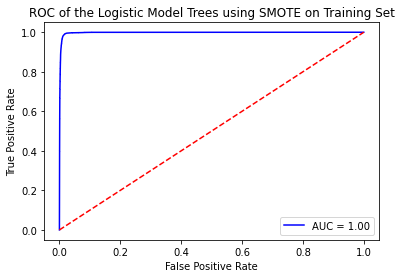

Trian error: 0.013508474576271134


In [68]:
y_train_num = y_train_smoted.copy()
y_train_num.replace('pos', 1, inplace=True)
y_train_num.replace('neg', 0, inplace=True)

y_predict = []
for instance in weka_train_smoted:
    y_predict.append(LMT_model.classify_instance(instance))

# confusion matrix
c_m = confusion_matrix(y_train_num, y_predict, labels=[0,1])
print('Confusion Matrix: \n', c_m)

# ROC and AUC
y_predict_proba = LMT_model.distributions_for_instances(weka_train_smoted)
fpr, tpr, thresholds = roc_curve(y_train_num, y_predict_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC and AUC:')
plt.title('ROC of the Logistic Model Trees using SMOTE on Training Set')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# train error
train_error = 1-accuracy_score(y_train_num, y_predict)
print('Trian error:', train_error)

#### LMT model using SMOTE on test set

Confusion Matrix: 
 [[15295   330]
 [   46   329]]
ROC and AUC:


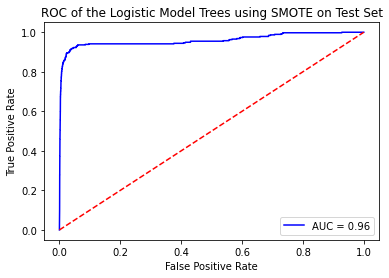

Test error: 0.023499999999999965


In [67]:
y_predict = []
for instance in weka_test:
    y_predict.append(LMT_model.classify_instance(instance))

# confusion matrix
c_m = confusion_matrix(y_test, y_predict, labels=[0,1])
print('Confusion Matrix: \n', c_m)

# ROC and AUC
y_predict_proba = LMT_model.distributions_for_instances(weka_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba[:, 1])
roc_auc = auc(fpr, tpr)

print('ROC and AUC:')
plt.title('ROC of the Logistic Model Trees using SMOTE on Test Set')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# test error
test_error = 1-accuracy_score(y_test, y_predict)
print('Test error:', test_error)

**ANSWER**: Comparing the results with those of 2e, we can get the table below.

| Model | Test Error | Recall | Precision |
| ----- | ---------- | ------ | --------- |
| LMT not using SMOTE | 0.009624999999999995 | 0.7173 | 0.8486 |
| LMT using SMOTE | 0.023499999999999965 | 0.8773 | 0.4992 |

We could see that the overall test error becomes higher after using SMOTE. However, the recall (true positive rate) also becomes much larger when using SMOTE, though precision becomes lower. For this data set, I believe recall is more important than  precsion, because we want to find out all APS failures even with low precision. Therefore, though with a larger test error, I think the model using SMOTE is the better one.

In [99]:
jvm.stop()

## 3. ISLR 6.6.3

### (a) As we increase s from 0, the training RSS will:

**ANSWER**: **(iv. Steadily decrease)** As s increases, the constarint on coefficients woule be loose, so the linear regression could be more flexible. Therefore, the training RSS will steadily decrease.

### (b) Repeat (a) for test RSS.

**ANSWER**: **(ii. Decrease initially, and then eventually start increasing in a U shape)** At first, with s increasing, the constraint loosens and the fexibility of the model increase, so the test RSS will decrease. However, after s becomes very larger, the model starts to overfit and then the test RSS begins to increase.

### (c) Repeat (a) for variance.

**ANSWER**: **(iii. Steadily increase)** As s increases, the model becomes more flexible but also more vulnerable to nosie. Therefore, the variance will steadily increase. 

### (d) Repeat (a) for (squared) bias.

**ANSWER**: **(iv. Steadily decrease)** As s increases, increasing flexibility of the model would result in smaller bias. So the (squared) bias will steadily decrease. 

### (e) Repeat (a) for the irreducible error.

**ANSWER**: **(v. Remain constant)** The irreducible error is caused by the natural noise of the object we want to estimate. It is independent of model flexibility, so it will just remain constant.

## 4. ISLR 6.6.5

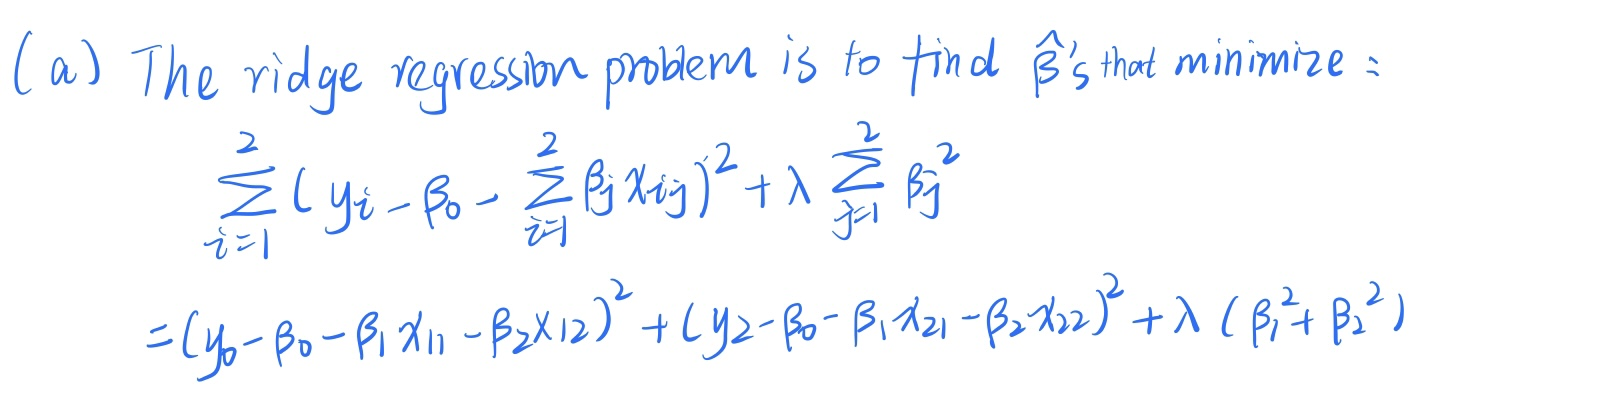

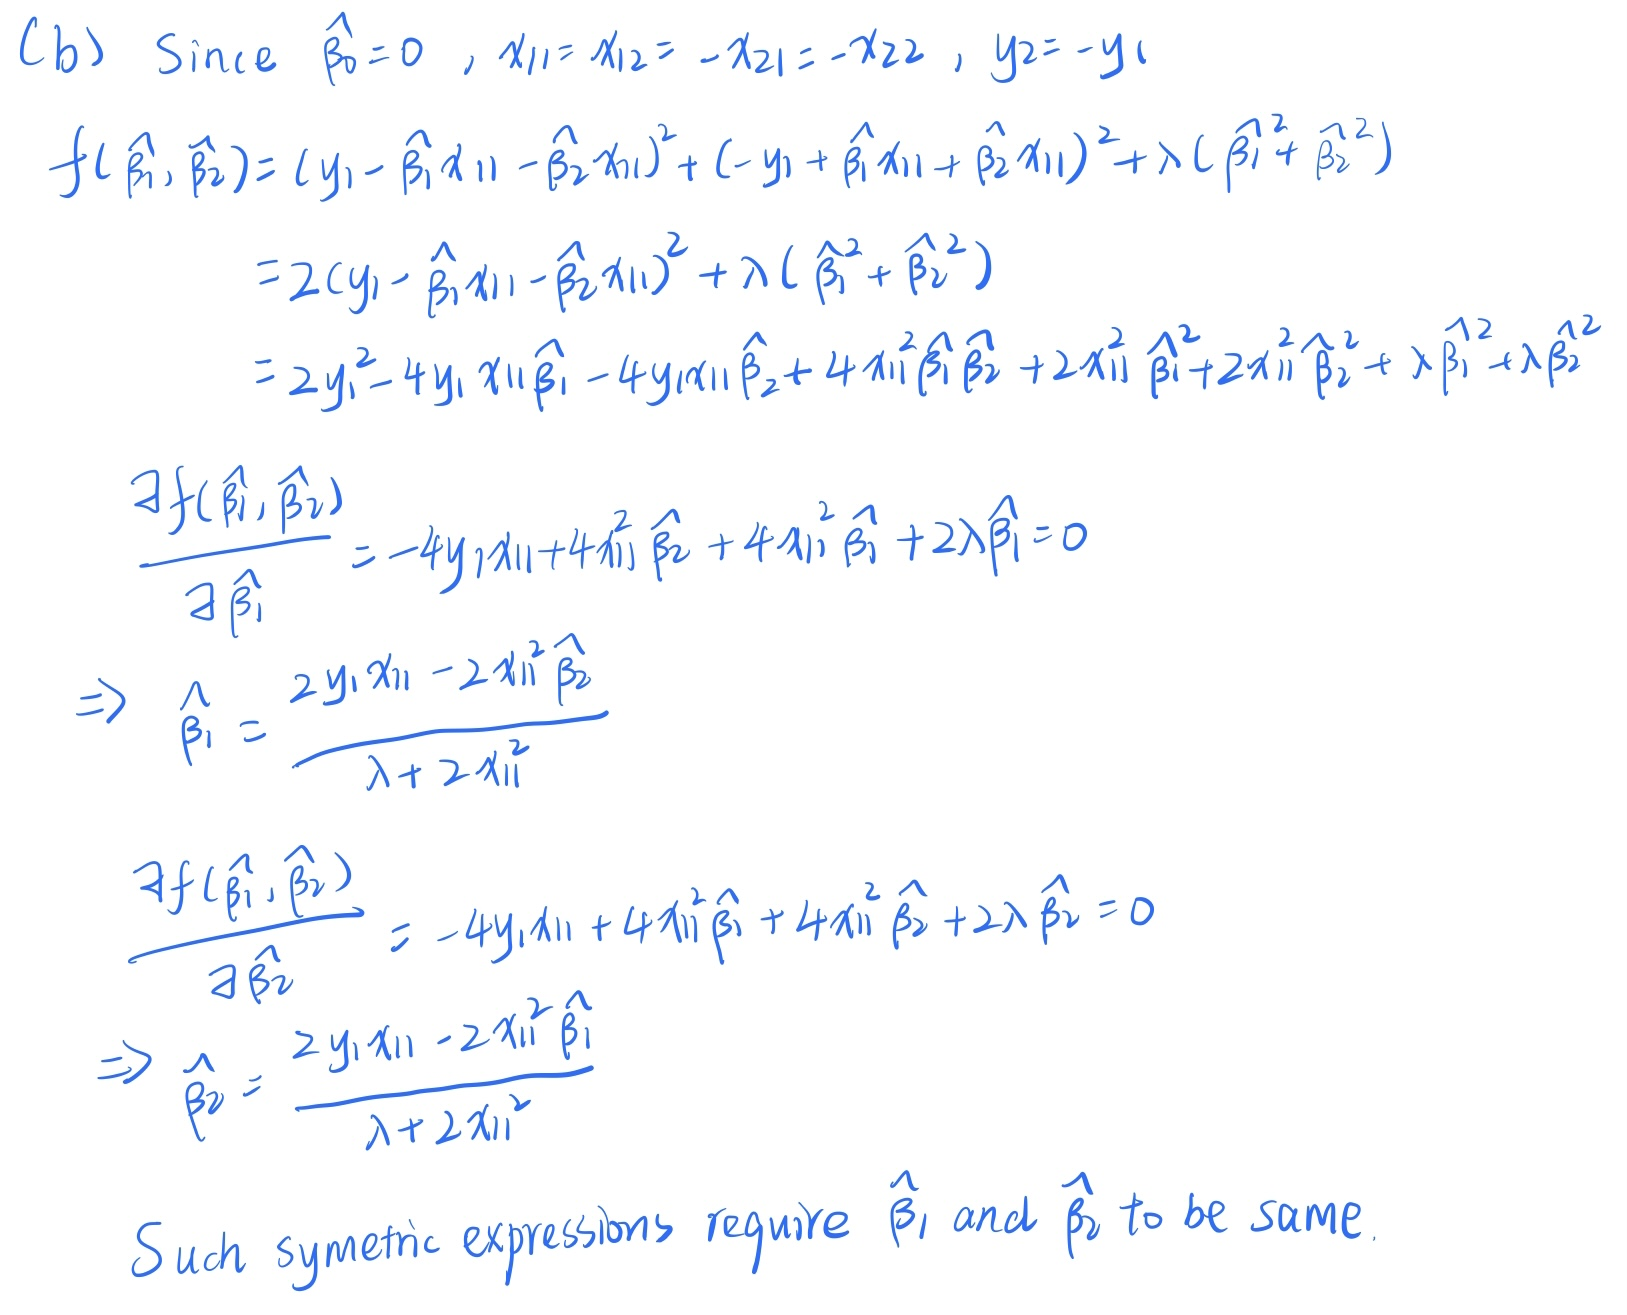

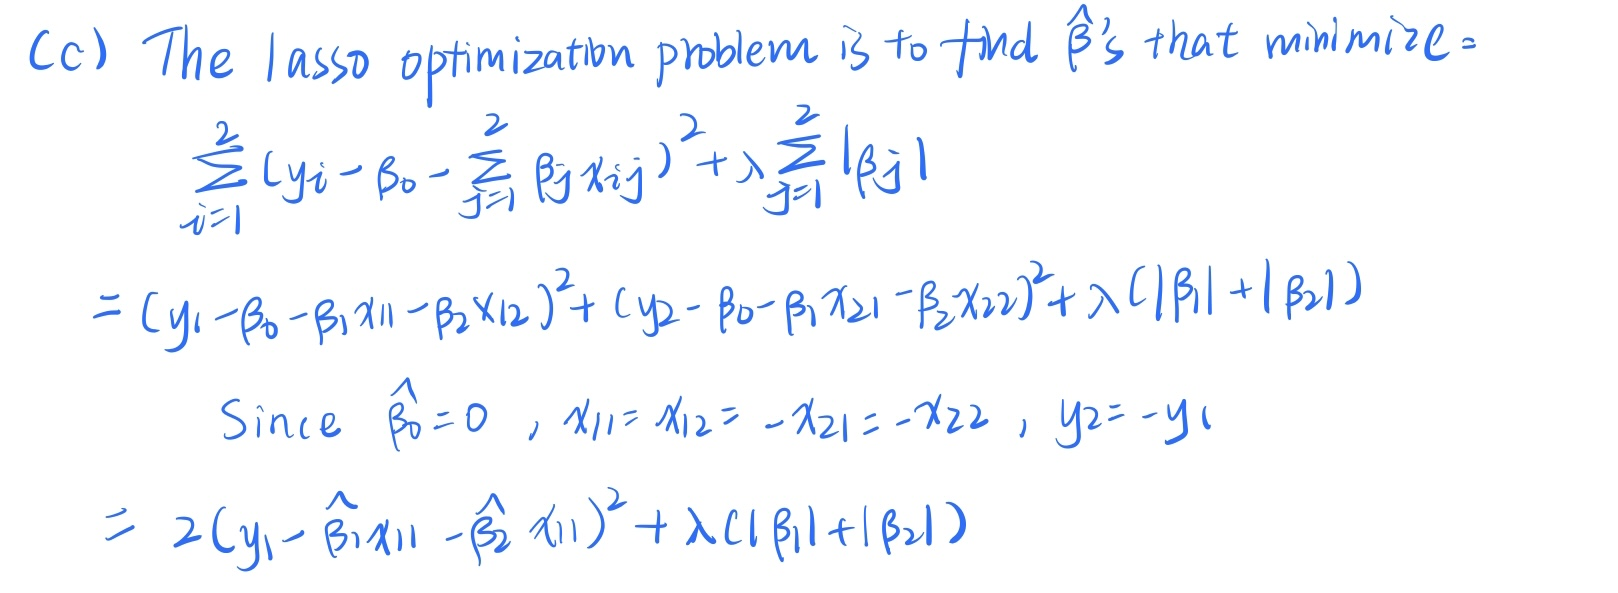

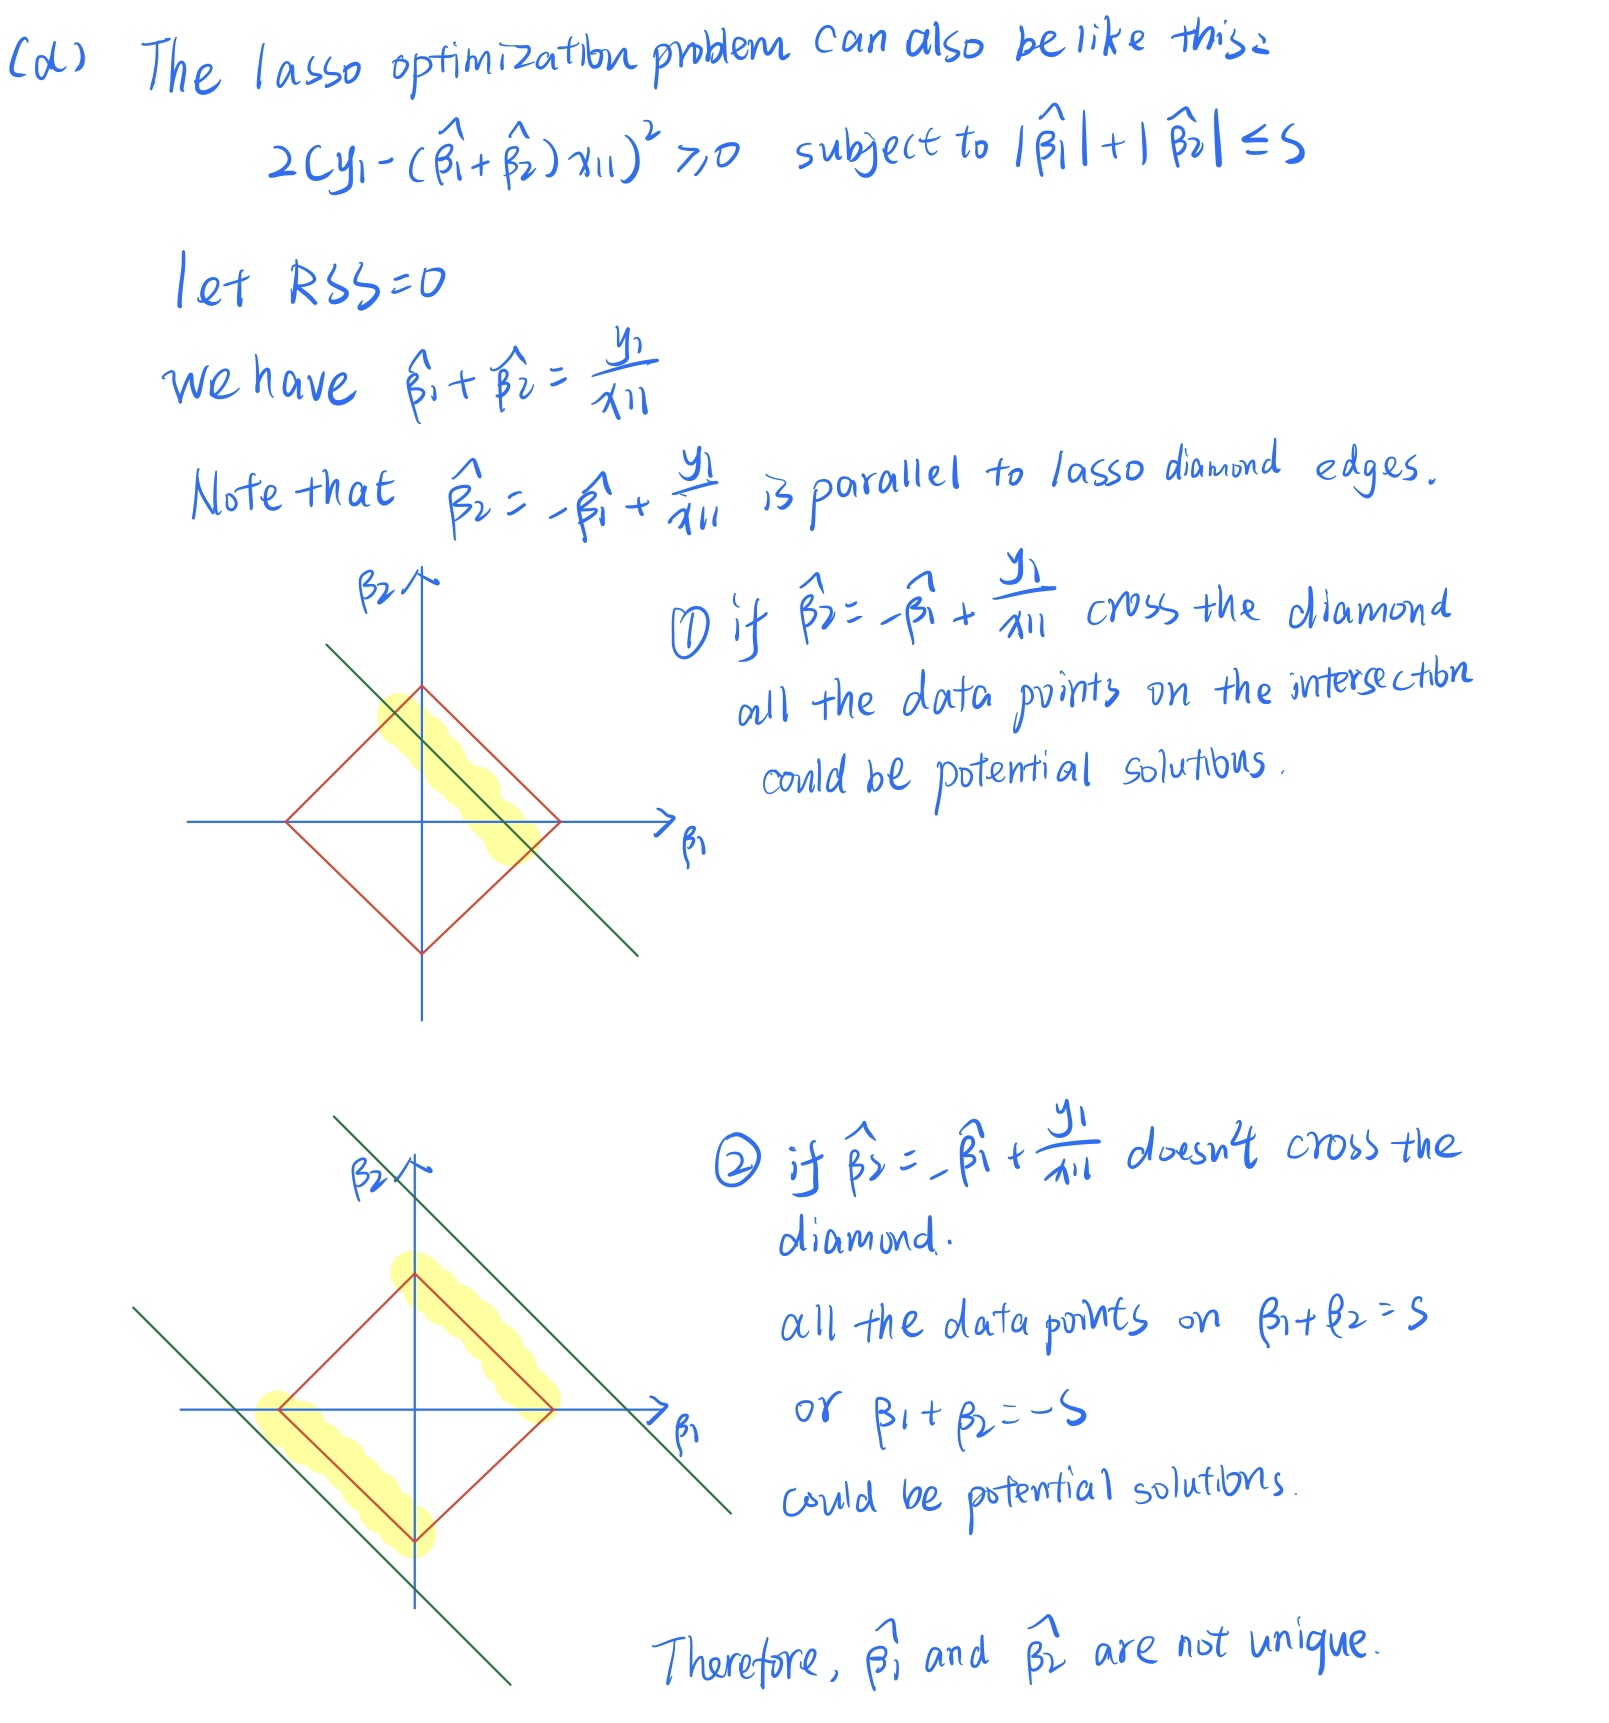

## 5. ISLR 8.4.5

(1) Majority vote approach: We have 6 red and 4 green, so it would be classified to **red**.

(2) Classify based on the average probability: (0.1+0.15+0.2+0.2+0.55+0.6+0.6+0.65+0.7+0.75)/10 = 0.45 < 0.5 So it would be classified to **green**.

## 6. ISLR 9.7.3

### (a)

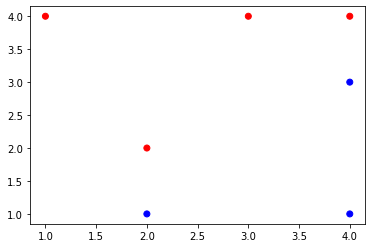

In [94]:
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
y = ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']
plt.figure()
plt.scatter(x1, x2, c=y)
plt.show()

### (b)

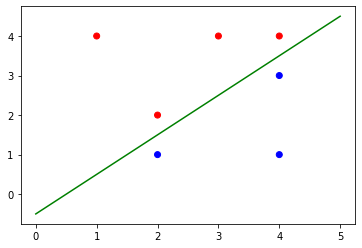

In [95]:
plt.figure()
plt.plot([0, 5], [-0.5, 4.5], 'green')
plt.scatter(x1, x2, c=y)
plt.show()

**ANSWER**: We should note that the optimal separating hyperplane should cross the midpoints between (2,1) and (2,2) and between (4,3) and (4,4), so we get **x1 - x2 - 0.5 = 0**. 

### (c)

**ANSWER**: Classify to Red if **0.5 - x1 + x2 > 0**, and classify to Blue otherwise.

### (d)

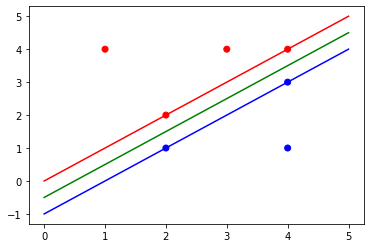

In [96]:
plt.figure()
plt.plot([0, 5], [-0.5, 4.5], 'green')
plt.plot([0, 5], [0, 5], 'red')
plt.plot([0, 5], [-1, 4], 'blue')
plt.scatter(x1, x2, c=y)
plt.show()

### (e)

**ANSWER**: The support vectors are (2,1), (2,2), (4,3) and (4,4).

### (f)

**ANSWER**: The seventh observation is far from the hyperplane. The maximal margin hyperplane is only affected by the support vectors, so a slight movement of the seventh observation would not affect it.

### (g)

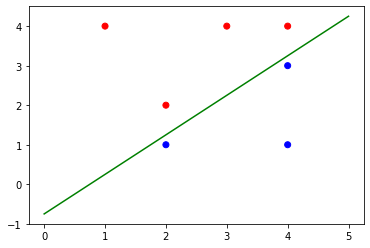

In [97]:
plt.figure()
plt.plot([0, 5], [-0.75, 4.25], 'green')
plt.scatter(x1, x2, c=y)
plt.show()

**ANSWER**: Equation for this hyperplane: **x1 - x2 - 0.75 = 0**

### (h)

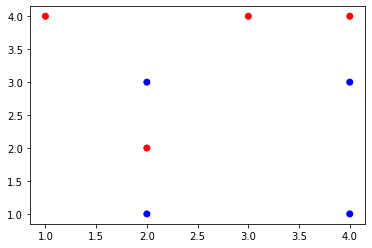

In [98]:
# Add (2,3) as blue
x1 = [3, 2, 4, 1, 2, 4, 4, 2]
x2 = [4, 2, 4, 4, 1, 3, 1, 3]
y = ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue']
plt.figure()
plt.scatter(x1, x2, c=y)
plt.show()

## References and Citations

#### 1. sklearn.impute.SimpleImputer
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

#### 2. Plot correlation matrix using pandas
https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

https://seaborn.pydata.org/generated/seaborn.heatmap.html

#### 3. sklearn.linear_model.RidgeCV
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html

#### 4. sklearn.linear_model.LassoCV
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

#### 5. sklearn.preprocessing.StandardScaler
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

#### 6. sklearn.decomposition.PCA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

#### 7. sklearn.model_selection.cross_val_score
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

#### 8. XGBoost Documentation
https://xgboost.readthedocs.io/en/latest/

https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster

https://rdrr.io/cran/xgboost/man/xgb.cv.html

#### 9. Different Ways to Compensate for Missing Values In a Dataset (Data Imputation with examples)
https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

#### 10. sklearn.ensemble.RandomForestClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### 11. Weka
https://weka.sourceforge.io/doc.dev/weka/classifiers/Classifier.html

https://fracpete.github.io/python-weka-wrapper3

#### 12. SMOTE

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html